# Strategy Performance Comparison

This notebook loads and runs all implemented trading strategies, visualizes their behavior, and compares their overall performance.

## 1. Setup and Imports

First, we import the necessary libraries for data manipulation and plotting, as well as all the custom strategy classes we have defined in the `.py` files.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

try:
    from PriceLoader import PriceLoader
    from MovingAverageStrategy import Strategy
    from MovingAverageStrategy import MovingAverageStrategy
    from MACDStrategy import MACDStrategy
    from RSIStrategy import RSIStrategy
    from VolatilityBreakoutStrategy import VolatilityBreakoutStrategy
    from BenchmarkStrategy import BenchmarkStrategy
except ImportError as e:
    print(f"Fatal! Source Broken. Error:{e}")

DATA_DIR = "/Users/laurisli/Desktop/FINM32500/HW2/Data"
INITIAL_CASH = 1_000_000

## 2. Run All Strategies and Collect Results

We will instantiate each strategy and run its backtest. The results, particularly the portfolio value over time, are stored in a dictionary for later comparison.

In [2]:
import time

price_loader = PriceLoader(data_dir=DATA_DIR)

strategies = {
    "Buy and Hold Benchmark": BenchmarkStrategy(loader=price_loader),
    "Moving Average (20/50)": MovingAverageStrategy(loader=price_loader, short_window=20, long_window=50),
    "MACD (12/26/9)": MACDStrategy(loader=price_loader, short_window=12, long_window=26, signal_window=9),
    "RSI (14, 30)": RSIStrategy(loader=price_loader, rsi_window=14, oversold_threshold=30),
    "Volatility Breakout (20)": VolatilityBreakoutStrategy(loader=price_loader, cal_std_window=20)
}

results = {}

start_time = time.time()
for name, strategy_obj in strategies.items():
    print(f"Now Running Strategy: {name}")
    strategy_obj.run_backtest()
    results[name] = strategy_obj.portfolio_value
end_time = time.time()
print(f'Execution Time: {end_time - start_time} seconds.')

PriceLoader initialized. Found 422 local price files.
Now Running Strategy: Buy and Hold Benchmark
Running benchmark strategy...
Skipping purchase of JNJ on 2005-01-03: insufficient cash.
Skipping purchase of JPM on 2005-01-03: insufficient cash.
Skipping purchase of K on 2005-01-03: insufficient cash.
Skipping purchase of KEY on 2005-01-03: insufficient cash.
Skipping purchase of KIM on 2005-01-03: insufficient cash.
Skipping purchase of KLAC on 2005-01-03: insufficient cash.
Skipping purchase of KMB on 2005-01-03: insufficient cash.
Skipping purchase of KMX on 2005-01-03: insufficient cash.
Skipping purchase of KO on 2005-01-03: insufficient cash.
Skipping purchase of KR on 2005-01-03: insufficient cash.
Skipping purchase of L on 2005-01-03: insufficient cash.
Skipping purchase of LEN on 2005-01-03: insufficient cash.
Skipping purchase of LH on 2005-01-03: insufficient cash.
Skipping purchase of LHX on 2005-01-03: insufficient cash.
Skipping purchase of LII on 2005-01-03: insufficien

We tried to vectorize trading in the backtest engine as much as possible. Final Execution Time for all S&P 500 tickers simulation: ~0.71s.

## 3-A. Strategy Analysis


### 3.1 Plot 1: Signal Overlay on Price Chart

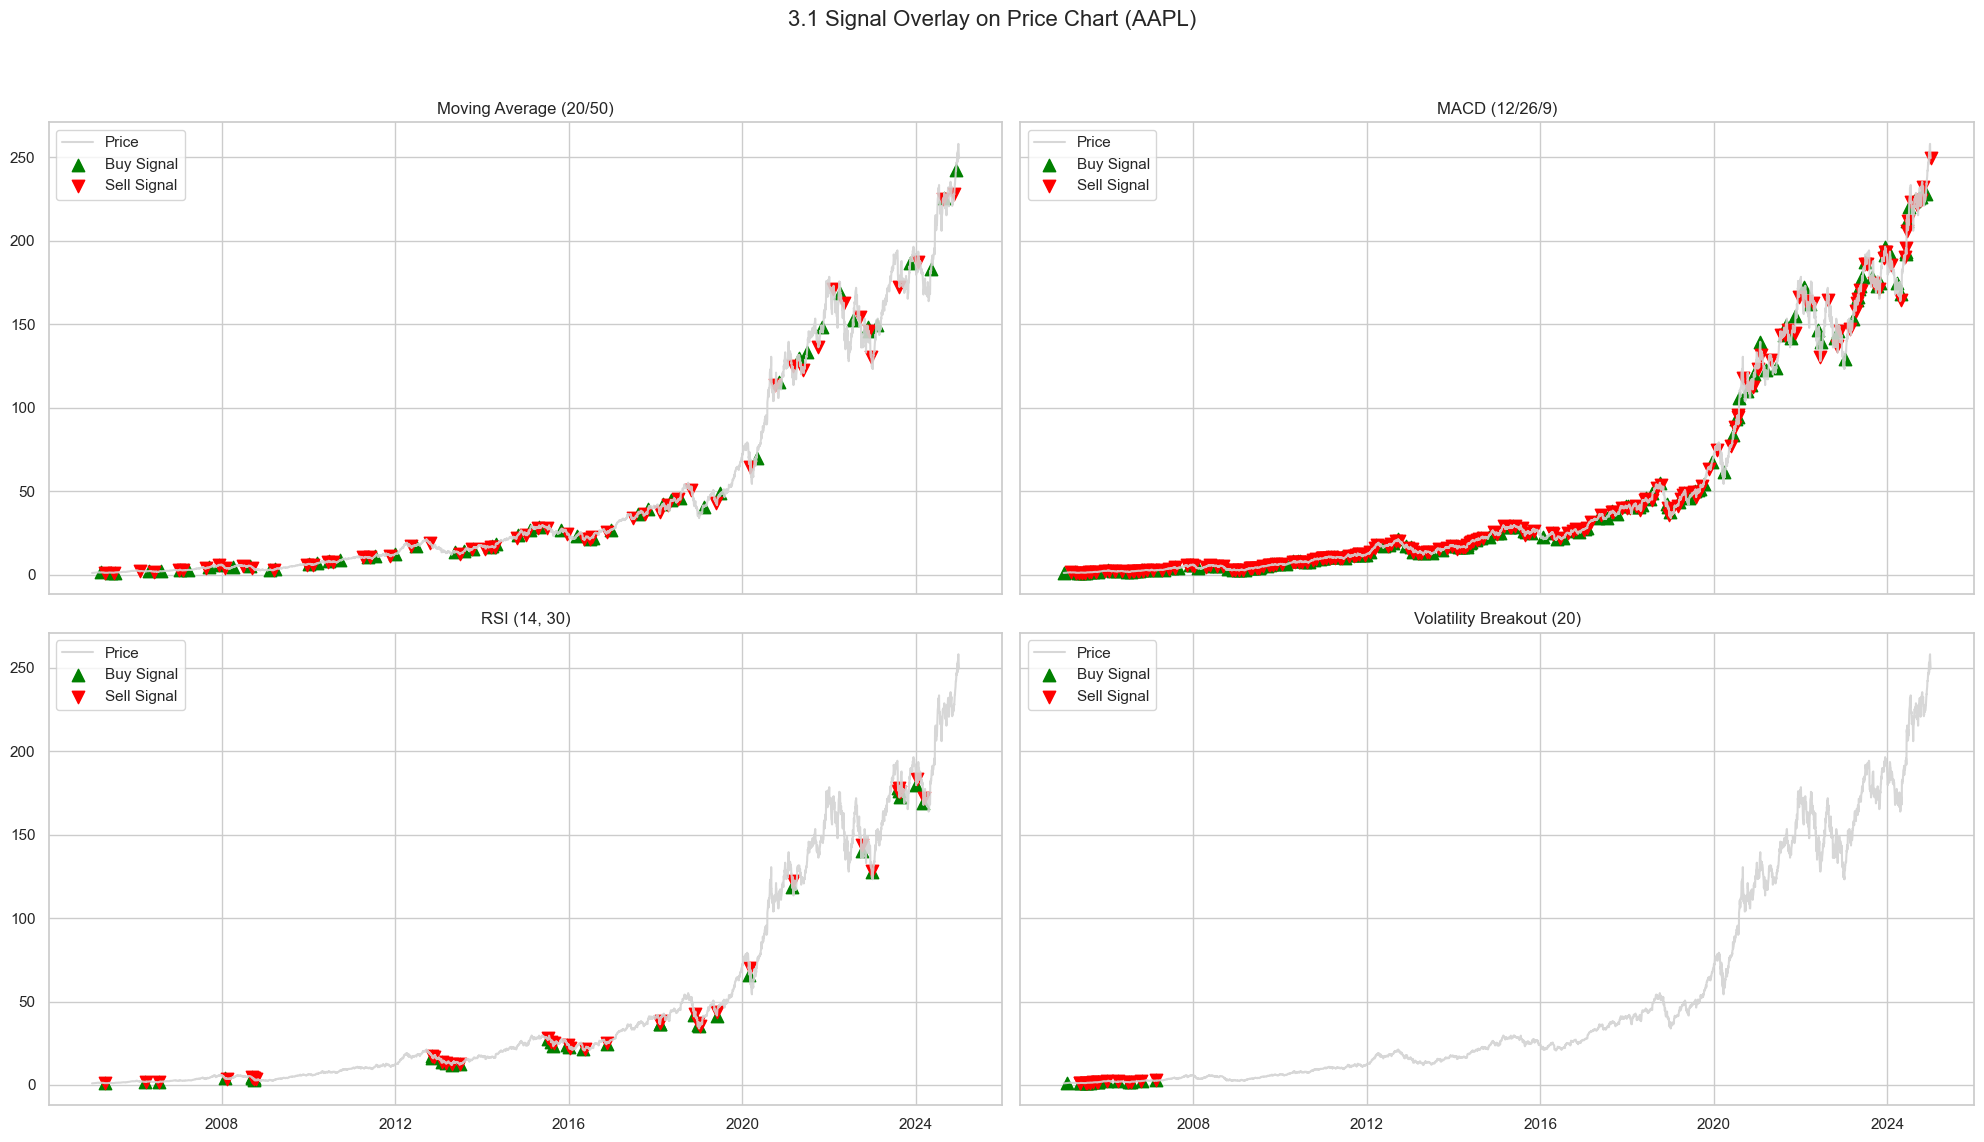

In [3]:
ticker_to_visualize = 'AAPL'

active_strategies = {
    "Moving Average (20/50)": strategies["Moving Average (20/50)"],
    "MACD (12/26/9)": strategies["MACD (12/26/9)"],
    "RSI (14, 30)": strategies["RSI (14, 30)"],
    "Volatility Breakout (20)": strategies["Volatility Breakout (20)"]
}

# Create a figure with 2x2 subplots for Signal Overlays
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle('3.1 Signal Overlay on Price Chart (AAPL)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (name, strategy_obj) in enumerate(active_strategies.items()):
    ax = axes[i]
    
    raw_signals = strategy_obj.generate_signals()
    signals = raw_signals.shift(1)
    trades = signals.diff().fillna(0)
    buy_points = trades[trades[ticker_to_visualize] == 1].index
    sell_points = trades[trades[ticker_to_visualize] == -1].index
    
    # --- Plotting ---
    ax.plot(strategy_obj.prices.index, strategy_obj.prices[ticker_to_visualize], label='Price', color='lightgray', alpha=0.9)
    ax.scatter(buy_points, strategy_obj.prices.loc[buy_points][ticker_to_visualize], label='Buy Signal', marker='^', color='green', s=80)
    ax.scatter(sell_points, strategy_obj.prices.loc[sell_points][ticker_to_visualize], label='Sell Signal', marker='v', color='red', s=80)
    ax.set_title(name)
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.2 Plot 2: Holdings Over Time

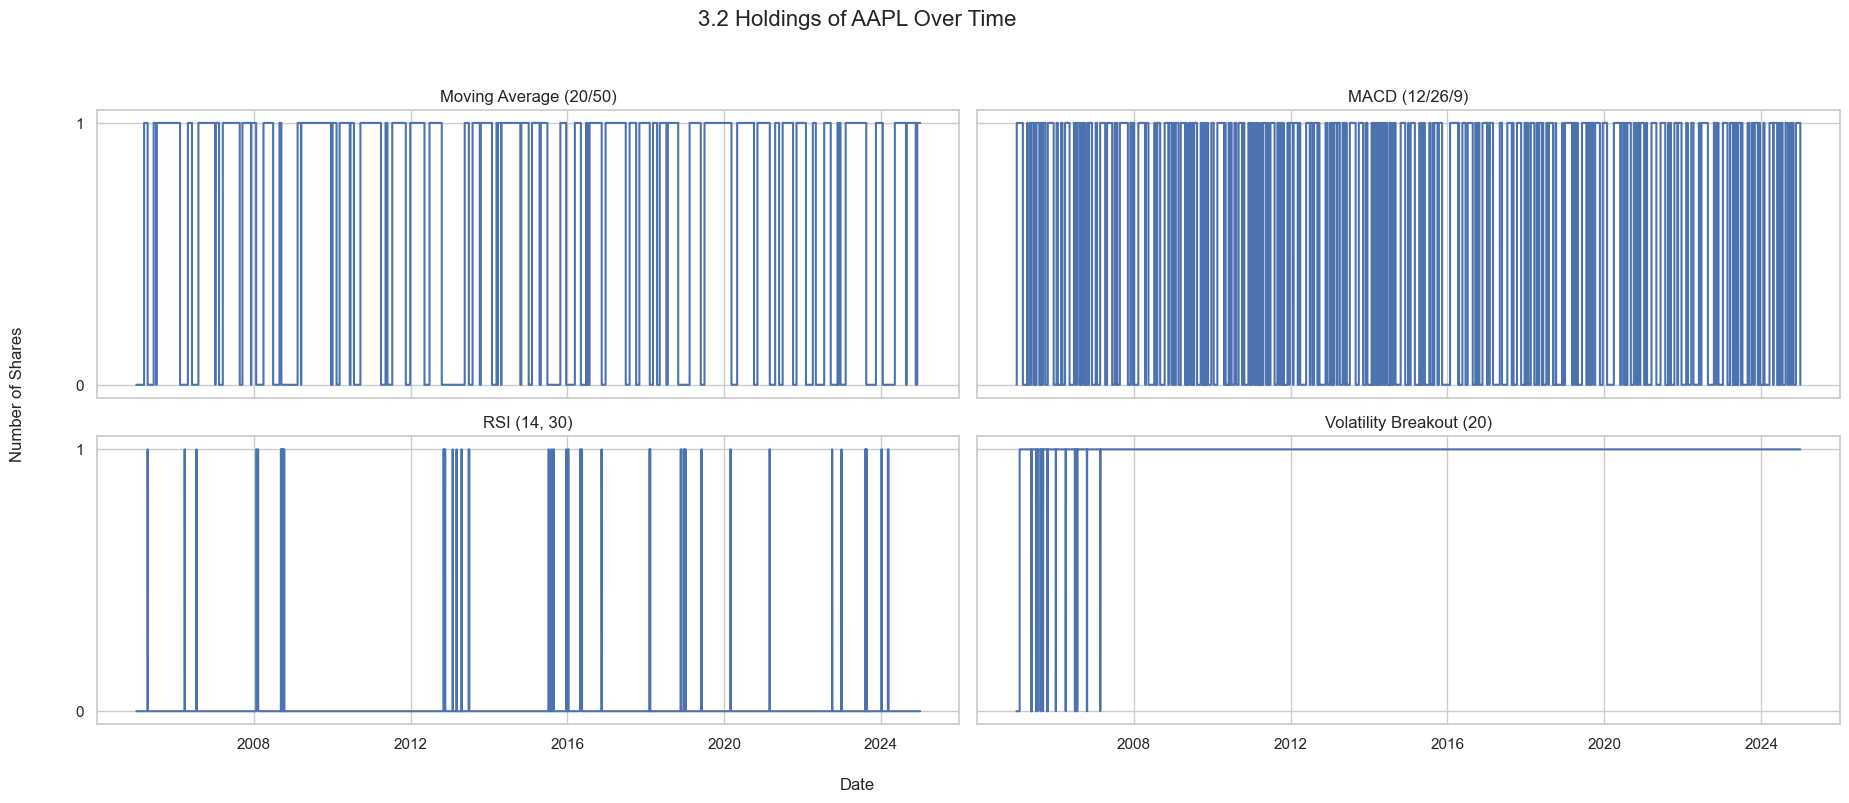

In [4]:
# Create a figure with 2x2 subplots for Holdings
fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharex=True, sharey=True)
fig.suptitle(f'3.2 Holdings of {ticker_to_visualize} Over Time', fontsize=16)

axes = axes.flatten()

for i, (name, strategy_obj) in enumerate(active_strategies.items()):
    ax = axes[i]
    ax.step(strategy_obj.holdings_df.index, strategy_obj.holdings_df[ticker_to_visualize], where='post')
    ax.set_title(name)
    ax.set_yticks([0, 1])
    ax.grid(True)

# Add shared labels
fig.text(0.5, 0.01, 'Date', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Number of Shares', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.1, 0.03, 1, 0.95])
plt.show()

### 3.3 Plot 3: Cash Balance Over Time

The cash balance decreases on a buy and increases on a sell. It remains flat when no trades occur.

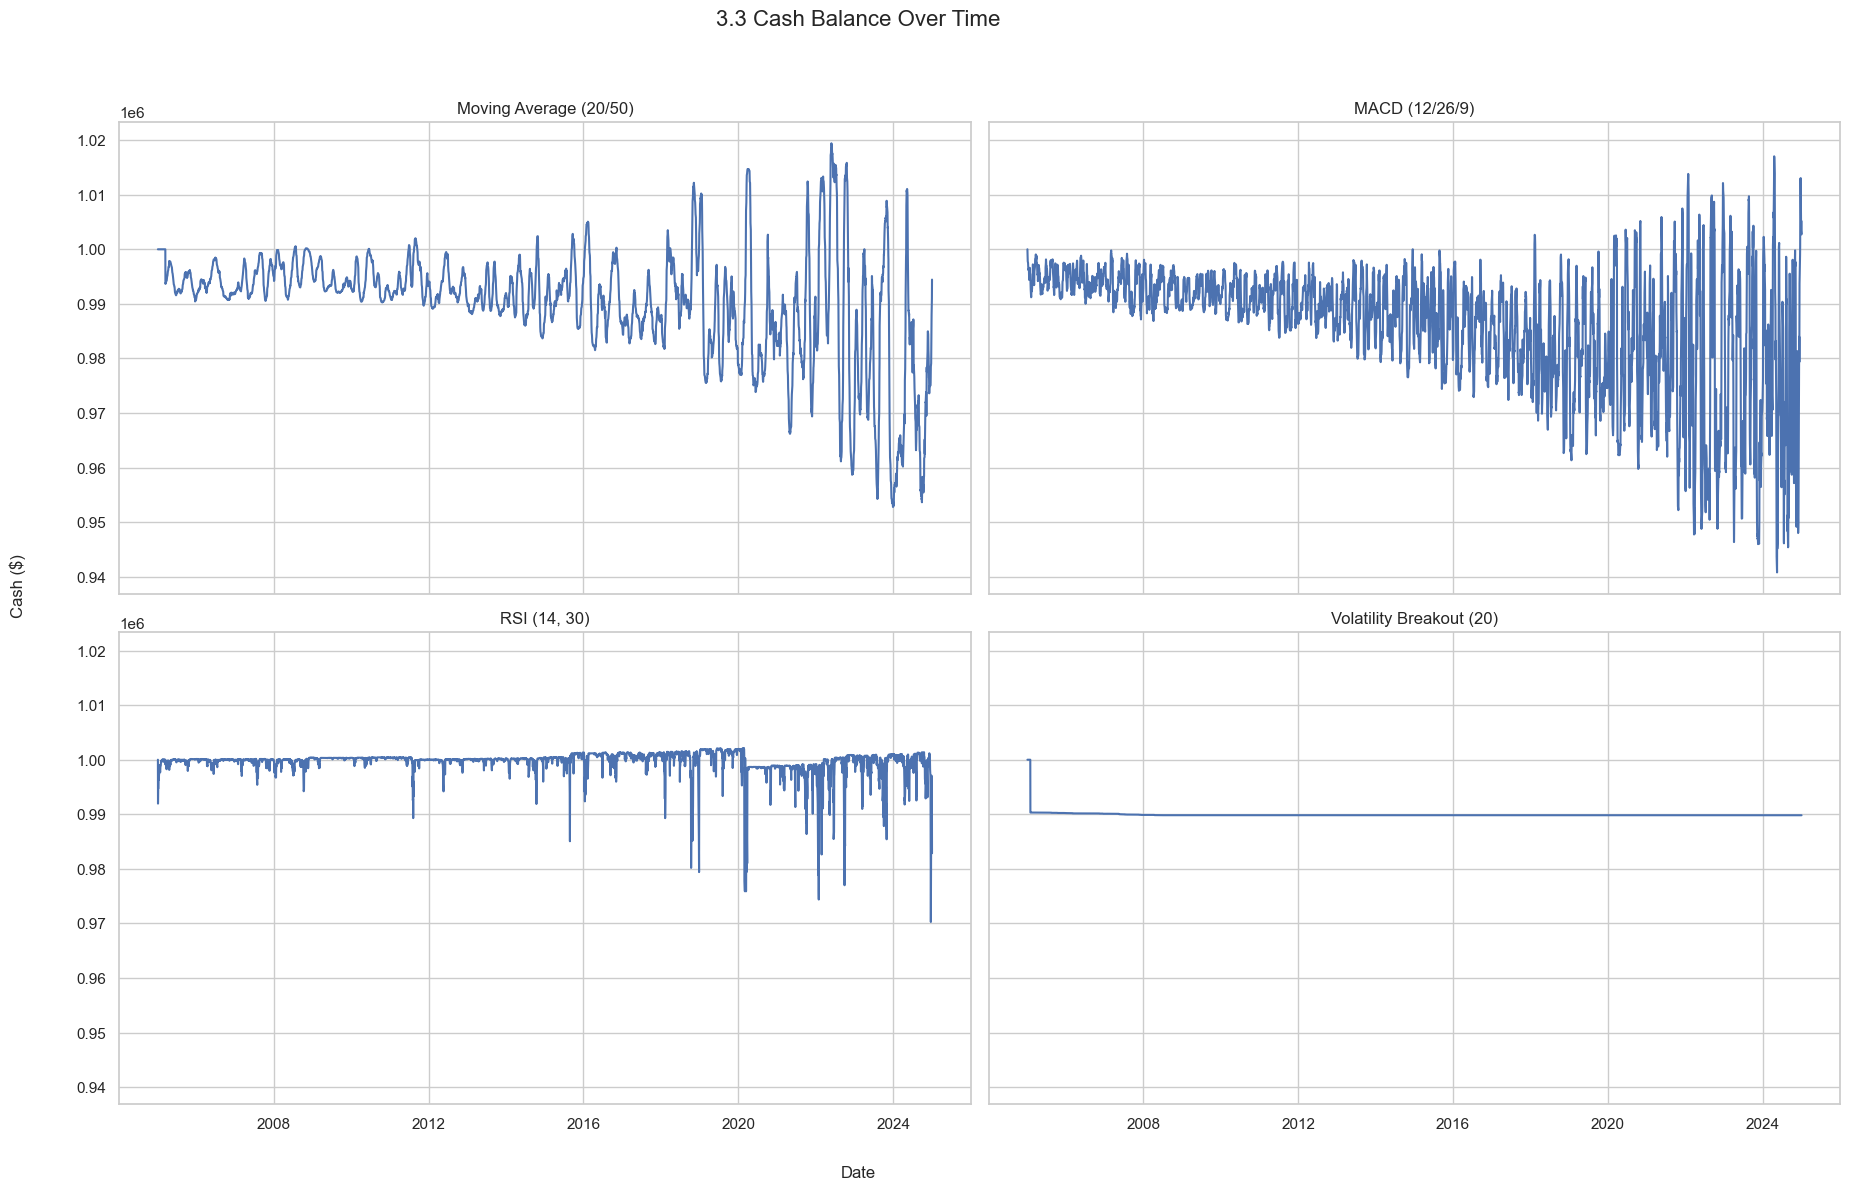

In [5]:
# Create a figure with 2x2 subplots for Cash Balance
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle('3.3 Cash Balance Over Time', fontsize=16)

axes = axes.flatten()

for i, (name, strategy_obj) in enumerate(active_strategies.items()):
    ax = axes[i]
    ax.plot(strategy_obj.cash_over_time.index, strategy_obj.cash_over_time, label='Cash Balance')
    ax.set_title(name)
    ax.grid(True)
    
# Add shared labels
fig.text(0.5, 0.01, 'Date', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Cash ($)', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.1, 0.03, 1, 0.95])
plt.show()

### 3.4 Plot 4: Total Portfolio Value

## 4. Comparative Analysis Across All Strategies

Now we compare the cumulative Profit and Loss (PnL) of all strategies on a single chart to evaluate their relative performance.

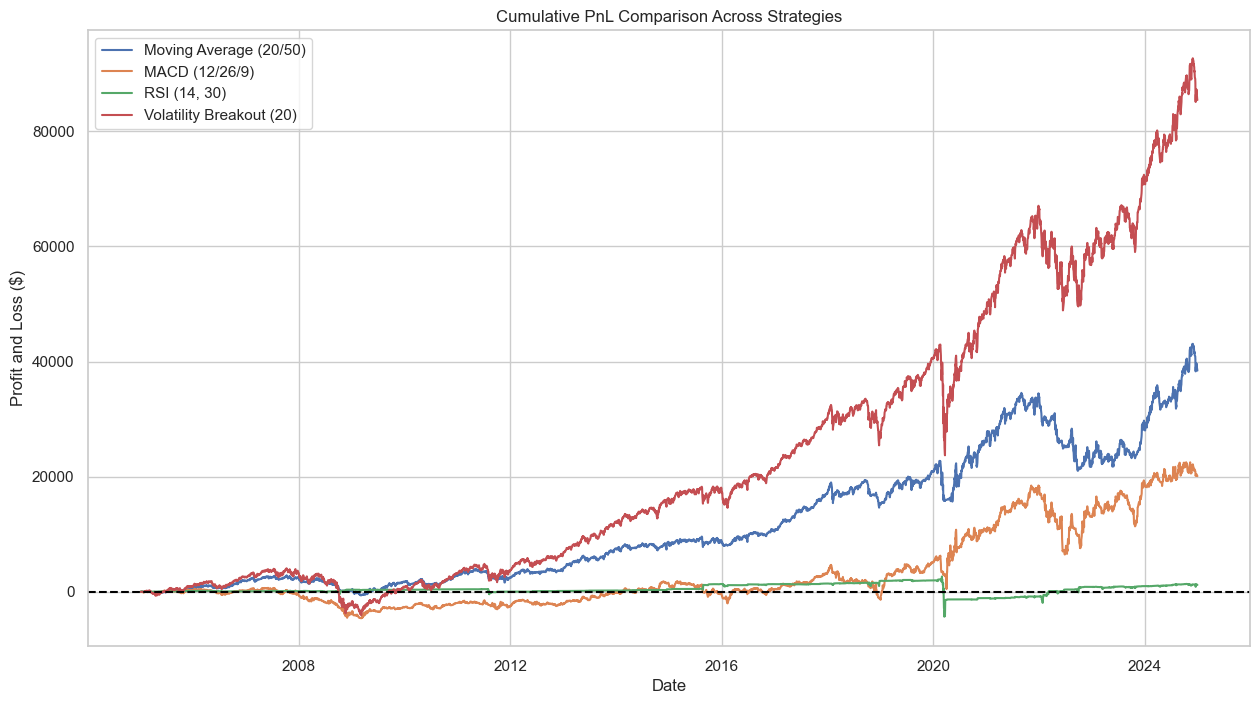

In [6]:
# Create a DataFrame with PnL for each strategy
pnl_df = pd.DataFrame()
for name, portfolio_values in results.items():
    if portfolio_values is not None and name != 'Buy and Hold Benchmark':
        pnl_df[name] = portfolio_values - INITIAL_CASH

plt.figure(figsize=(15, 8))
for column in pnl_df.columns:
    plt.plot(pnl_df.index, pnl_df[column], label=column)

# For this step we omit the benchmark, we will display benchmark in the next code block
plt.title('Cumulative PnL Comparison Across Strategies')
plt.xlabel('Date')
plt.ylabel('Profit and Loss ($)')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

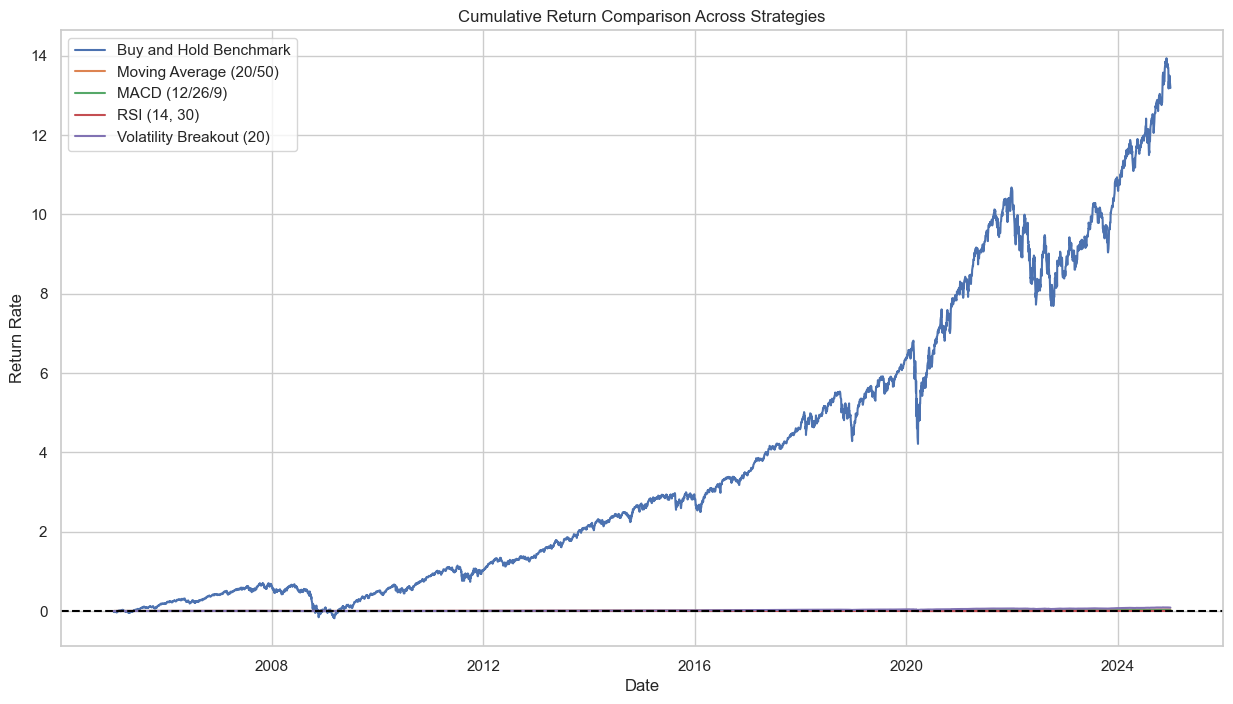

In [7]:
#return rate for each strategy
return_df = pd.DataFrame()
for name, portfolio_values in results.items():
    if portfolio_values is not None:
        return_df[name] = (portfolio_values / INITIAL_CASH) - 1
plt.figure(figsize=(15, 8))
for column in return_df.columns:
    plt.plot(return_df.index, return_df[column], label=column)

plt.title('Cumulative Return Comparison Across Strategies')
plt.xlabel('Date')
plt.ylabel('Return Rate')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()


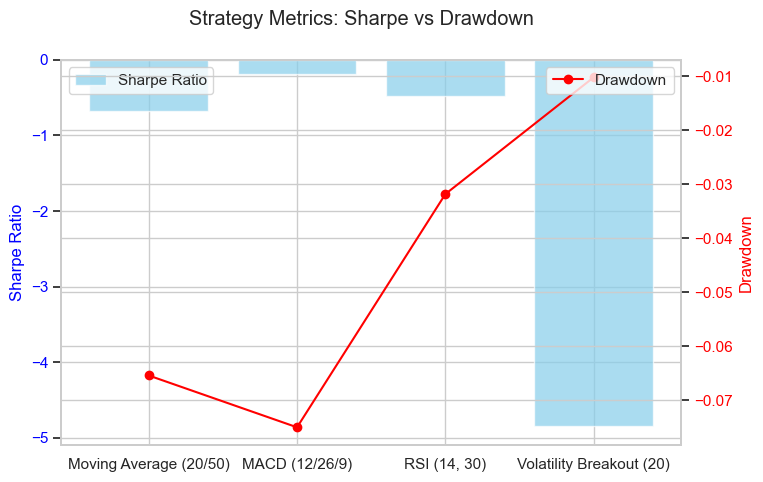

In [8]:
metrics = {}
for name,strategy in strategies.items():
    if name != 'Buy and Hold Benchmark':
        sharpe,drawdown = strategy._get_sharpe_drawdown()
        metrics[name] = (sharpe,drawdown)

strategies = list(metrics.keys())
sharpe_values = [metrics[s][0] for s in strategies]
drawdown_values = [metrics[s][1] for s in strategies]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.bar(strategies, sharpe_values, color='skyblue', label='Sharpe Ratio', alpha=0.7)
ax1.set_ylabel('Sharpe Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(strategies, drawdown_values, color='red', marker='o', label='Drawdown')
ax2.set_ylabel('Drawdown', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Strategy Metrics: Sharpe vs Drawdown')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

## 5. Reflections and Conclusion

### Signal Behavior
- **Trend-Following (Moving Average, MACD):** These strategies aim to capture the momentum of market trends. They perform well in sustained bull or bear markets but can suffer from "whipsaws" (rapidly alternating buy/sell signals) in sideways or volatile markets, leading to losses from transaction costs.
- **Mean-Reversion (RSI):** This strategy operates on the opposite principle, buying assets when they are "oversold" (RSI < 30) and expecting them to revert to their mean. It can be profitable in ranging markets but may incur significant losses if it buys into a strong, persistent downtrend.
- **Volatility-Based (Volatility Breakout):** This strategy attempts to capitalize on changes in volatility. Its effectiveness depends heavily on the market regime.
- **Benchmark (Buy and Hold):** This passive strategy's performance is entirely dependent on the overall market direction. It provides a crucial baseline to determine if the active strategies are adding any value (alpha).

### Execution Constraints
Our backtesting framework imposed several key constraints:
1.  **No Short Positions:** We could only profit from rising prices, limiting opportunities in bear markets.
2.  **Fixed Position Sizing (1 Share):** This is unrealistic. In practice, position size would be based on a fixed dollar amount or a percentage of the portfolio to manage risk. Our simple model underweights high-priced stocks and overweights low-priced stocks.
3.  **Acting on Previous Day's Signal:** Our framework correctly avoids lookahead bias by using T-1 data for trades on day T. This is a critical feature for a valid backtest.
4.  **Transaction Costs:** We included a simple percentage-based transaction cost, which adds a layer of realism. Higher trading frequency (like in whipsaw scenarios) will lead to higher cost drag.

### Performance Summary

In this backtest, the **Buy and Hold Benchmark** strategy was the top performer:

- **Final Portfolio Value:** The benchmark strategy's final portfolio value was approximately $14.18 million, far exceeding all other active trading strategies.
- **Sharpe Ratio:** The benchmark's Sharpe Ratio was 0.5747, the only strategy to record a positive Sharpe ratio, indicating the best risk-adjusted return.
- **Active Strategy Performance:** All active strategies (Moving Average, MACD, RSI, Volatility Breakout) ended with portfolio values only slightly above the initial capital and had negative Sharpe Ratios, meaning they did not generate positive returns for the risk taken.

**Conclusion**

Over the historical period covered by this backtest, none of the active trading strategies managed to outperform the simple Buy and Hold benchmark. This highlights how powerful a passive investment strategy can be in a long-term bull market. Active strategies must consistently beat the benchmark after accounting for transaction costs and risk to justify their use. Based on both the Sharpe Ratios and final returns, the **Buy and Hold Benchmark** was unequivocally the **most effective strategy** in this backtest.